<a href="https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-scalability?scriptVersionId=205994302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class ="alert alert-block alert-warning">
    
- This notebook aims to apply AutoGluon-TimeSeries as covered by https://paperswithcode.com/paper/autogluon-timeseries-automl-for-probabilistic on the M5 dataset

- we aim to deploy it and run on the validation set having successfully implemented on 1 time-series in https://www.kaggle.com/code/yorkyong/m5-forecasting-autogluon-1series

# Import Libraries

In [1]:
pip install autogluon thinc==8.2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of spacy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to de

In [2]:
import gc
import os
import psutil

import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import warnings  # To suppress warnings
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

import random  # For generating random numbers

# Function to set a fixed random seed for reproducibility
def seed_everything(seed):
    np.random.seed(seed)  # Set numpy random seed
    random.seed(seed)  # Set built-in random seed

seed_everything(seed=2024)  # Set the seed to 2024


# Load Dataset

In [3]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")  # Load calendar dataset
print(f"len(calendar):{len(calendar)}")  # Print the number of rows in calendar
calendar

len(calendar):1969


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
sales_train_evaluation = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
print(f"len(sales_train_evaluation): {len(sales_train_evaluation)}")
sales_train_evaluation.head()

len(sales_train_evaluation): 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")
print(f"len(sell_prices):{len(sell_prices)}")
sell_prices

len(sell_prices):6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
# Enhanced memory optimization function with object datatype handling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  # Initial memory usage in MB
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:  # Downcast numerics
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
        elif col_type == 'object':  # Handle object types
            if col == 'date':  # Convert date column to datetime
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
            else:
                df[col] = df[col].astype('category')  # Convert other object types to category
    end_mem = df.memory_usage().sum() / 1024**2  # Final memory usage in MB
    if verbose:
        print(f'Memory usage reduced to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [7]:
# Apply the optimized memory reduction function to each dataframe
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_evaluation = reduce_mem_usage(sales_train_evaluation)

Memory usage reduced to  0.13 Mb (40.4% reduction)
Memory usage reduced to 45.76 Mb (78.1% reduction)
Memory usage reduced to 96.30 Mb (78.7% reduction)


# Convert Sales Data to Long format

In [8]:
# Specify day columns up to d_1941 for the extended dataset
d_cols_eval = [f"d_{i}" for i in range(1, 1942)]
sales_train_evaluation_long = sales_train_evaluation.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    value_vars=d_cols_eval,
    var_name="d",
    value_name="sales"
)
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 59181090


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


# Label Endcode Calendar event

In [9]:
# Encode event-related features in the calendar dataframe
event_columns = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
le = LabelEncoder()
for col in event_columns:
    calendar[col] = le.fit_transform(calendar[col].astype(str))

# Merge with Calender data

In [10]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(calendar, on="d", how="left")
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,30,4,4,2,0,0,0


# Merge with Price data

In [11]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(
    sell_prices, 
    on=["store_id", "item_id", "wm_yr_wk"], 
    how="left"
)
sales_train_evaluation_long.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,30,4,4,2,0,0,0,NaN


# Define Train, Validation and Evaluation sets

In [12]:
train_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1500, 1914)])]
print("Train set sample:")
print(f"len(Train set): {len(train_set)}")
train_set.head()

Train set sample:
len(Train set): 12622860


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859


In [13]:
# Filter the validation set for d_1914 to d_1941
validation_set = sales_train_evaluation_long[sales_train_evaluation_long['d'].isin([f'd_{i}' for i in range(1914, 1942)])]
print("Validation set sample:")
print(f"len(Validation set): {len(validation_set)}")
validation_set.head()


Validation set sample:
len(Validation set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859


In [14]:
# Create a new DataFrame for the prediction period (d_1942 to d_1969)
forecast_days = [f'd_{i}' for i in range(1942, 1970)]
forecast_df = pd.DataFrame({'d': forecast_days})

# Generate one entry per product-store combination for each forecast day
prediction_set = sales_train_evaluation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
prediction_set = prediction_set.merge(forecast_df, how='cross')

# Merge with calendar data to add date information for the forecast period
prediction_set = prediction_set.merge(calendar, on='d', how='left')

# Merge with sell_prices to add price data, aligning with the correct store, item, and week
prediction_set = prediction_set.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print("Prediction set sample:")
print(f"len(Prediction set): {len(prediction_set)}")
prediction_set.head()


Prediction set sample:
len(Prediction set): 853720


,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812


In [15]:
# Apply the optimized memory reduction function to each dataframe
train_set = reduce_mem_usage(train_set)
validation_set = reduce_mem_usage(validation_set)
prediction_set = reduce_mem_usage(prediction_set)

Memory usage reduced to 531.02 Mb (43.5% reduction)
Memory usage reduced to 36.34 Mb (44.0% reduction)
Memory usage reduced to 28.20 Mb (50.3% reduction)


In [16]:
train_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
45704510,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,8.257812
45704511,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,3.970703
45704512,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,0,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.970703
45704513,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,10,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,4.640625
45704514,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1500,2,2015-03-08,11506,...,3,2015,30,4,4,2,1,0,1,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.980469
58327366,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,2.480469
58327367,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,3.980469
58327368,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,30,4,4,2,0,0,0,1.280273


In [17]:
validation_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
58327370,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,8.382812
58327371,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,3.970703
58327372,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.970703
58327373,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,0,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,4.640625
58327374,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1914,1,2016-04-25,11613,...,4,2016,30,4,4,2,0,0,0,2.880859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.980469
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,2.480469
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,3.980469
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,...,5,2016,30,4,4,2,0,0,0,1.280273


In [18]:
prediction_set

,id,item_id,dept_id,cat_id,store_id,state_id,d,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2016-05-23,11617,Monday,...,5,2016,30,4,4,2,0,0,0,8.382812
1,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1943,2016-05-24,11617,Tuesday,...,5,2016,30,4,4,2,0,0,0,8.382812
2,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1944,2016-05-25,11617,Wednesday,...,5,2016,30,4,4,2,0,0,0,8.382812
3,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1945,2016-05-26,11617,Thursday,...,5,2016,30,4,4,2,0,0,0,8.382812
4,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1946,2016-05-27,11617,Friday,...,5,2016,30,4,4,2,0,0,0,8.382812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1965,2016-06-15,11620,Wednesday,...,6,2016,30,4,4,2,0,1,1,1.000000
853716,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1966,2016-06-16,11620,Thursday,...,6,2016,30,4,4,2,0,0,0,1.000000
853717,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1967,2016-06-17,11620,Friday,...,6,2016,30,4,4,2,0,0,0,1.000000
853718,FOODS_3_827_WI_3_evaluation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,d_1968,2016-06-18,11621,Saturday,...,6,2016,30,4,4,2,0,0,0,1.000000


# Transform train_set into AutoGluon's TimeSeriesDataFrame

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12622860 entries, 45704510 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int8          
 15  event_type_1  int8          
 16  event_name_2  int8          
 17  event_type_2  int8          
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(8), datetime64[ns](1), float16(1), int16(3), int8(

In [20]:
# Step 1: Convert the 'date' column to datetime format
train_set['date'] = pd.to_datetime(train_set['date'])

# Step 2: Select only the relevant columns for AutoGluon, including target and covariates
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
train_set_for_autogluon = train_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
train_set_for_autogluon = train_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame format, specifying id_column and timestamp_column
train_set_for_autogluon = TimeSeriesDataFrame.from_data_frame(
    df=train_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [21]:
train_set_for_autogluon = reduce_mem_usage(train_set_for_autogluon)

Memory usage reduced to 218.00 Mb (0.0% reduction)


In [22]:
train_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2015-03-08      FOODS_1     CA_1      1     2   
                                2015-03-09      FOODS_1     CA_1      0     3   
                                2015-03-10      FOODS_1     CA_1      1     4   
                                2015-03-11      FOODS_1     CA_1      0     5   
                                2015-03-12      FOODS_1     CA_1      1     6   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20  HOUSEHOLD_2     WI_3      0     5   
                                2016-04-21  HOUSEHOLD_2     WI_3      0     6   
                                2016-04-22  HOUSEHOLD_2     WI_3      0     7   
                                2016-04-23  HOUSEHOLD_2     WI_3      0     1   
                                2016-04-24  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2015-03-08        1        0        1   
                                2015-03-09        1        1        1   
                                2015-03-10        1        0        0   
                                2015-03-11        0        1        1   
                                2015-03-12        0        1        1   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20        0        0        0   
                                2016-04-21        0        0        0   
                                2016-04-22        0        0        0   
                                2016-04-23        0        0        0   
                                2016-04-24        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2015-03-08    2.240234            30   
                                2015-03-09    2.240234            30   
                                2015-03-10    2.240234            30   
                                2015-03-11    2.240234            30   
                                2015-03-12    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20    5.941406            30   
                                2016-04-21    5.941406            30   
                                2016-04-22    5.941406            30   
                                2016-04-23    5.941406            30   
                                2016-04-24    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2015-03-08             4             4   
                                2015-03-09             4             4   
                                2015-03-10             4             4   
                                2015-03-11             4             4   
                                2015-03-12             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-04-20             4             4   
                                2016-04-21             4             4   
                                2016-04-22             4             4   
                                2016-04-23             4             4   
                                2016-04-24             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [23]:
# Check for missing values in each column of the DataFrame
missing_values = train_set_for_autogluon.isna().sum()

# Filter to show only columns with missing values
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sell_price    55736
dtype: int64


# TimeSeriesPredictor

In [24]:
# Step 1: Initialize the TimeSeriesPredictor with a primary eval_metric
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="sales",
    known_covariates_names=['dept_id', 'store_id','wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'event_name_1','event_type_1','event_name_2', 'event_type_2'] ,
    eval_metric="RMSSE"  # Primary metric for training
)

# Step 2: Fit the predictor with all models in the model zoo using default hyperparameters
predictor.fit(
    train_data=train_set_for_autogluon,
    presets="high_quality",
    excluded_model_types=[
        'AutoARIMA','Chronos[base]', 'TemporalFusionTransformer', 'DeepAR', 'PatchTST'
                         ]  
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241108_122318"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241108_122318'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       19.01 GB / 31.36 GB (60.6%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSSE,
 'excluded_model_types': ['AutoARIMA',
                          'Chronos[base]',
                          'TemporalFusionTransformer',
                          'DeepAR',
                          'PatchTST'],
 'hyperparameters': 'default',
 'known_covariates_names': ['dept_id',
                            'store_id',
                            'wday',


# Predict for Validation set 

In [25]:
# Step 1: Ensure 'date' is in datetime format
validation_set['date'] = pd.to_datetime(validation_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id','sales', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
validation_set_for_autogluon = validation_set[['id', 'date'] + covariate_columns].copy()

# Step 3: Sort the DataFrame by 'id' and 'date' to ensure correct order
validation_set_for_autogluon = validation_set_for_autogluon.sort_values(by=['id', 'date'])

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
validation_set_for_autogluon = TimeSeriesDataFrame(
    data=validation_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [26]:
validation_set_for_autogluon

dept_id store_id  sales  wday  \
item_id                         timestamp                                       
FOODS_1_001_CA_1_evaluation     2016-04-25      FOODS_1     CA_1      2     3   
                                2016-04-26      FOODS_1     CA_1      0     4   
                                2016-04-27      FOODS_1     CA_1      0     5   
                                2016-04-28      FOODS_1     CA_1      0     6   
                                2016-04-29      FOODS_1     CA_1      0     7   
...                                                 ...      ...    ...   ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  HOUSEHOLD_2     WI_3      0     5   
                                2016-05-19  HOUSEHOLD_2     WI_3      0     6   
                                2016-05-20  HOUSEHOLD_2     WI_3      0     7   
                                2016-05-21  HOUSEHOLD_2     WI_3      0     1   
                                2016-05-22  HOUSEHOLD_2     WI_3      0     2   

                                            snap_CA  snap_TX  snap_WI  \
item_id                         timestamp                               
FOODS_1_001_CA_1_evaluation     2016-04-25        0        0        0   
                                2016-04-26        0        0        0   
                                2016-04-27        0        0        0   
                                2016-04-28        0        0        0   
                                2016-04-29        0        0        0   
...                                             ...      ...      ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18        0        0        0   
                                2016-05-19        0        0        0   
                                2016-05-20        0        0        0   
                                2016-05-21        0        0        0   
                                2016-05-22        0        0        0   

                                            sell_price  event_name_1  \
item_id                         timestamp                              
FOODS_1_001_CA_1_evaluation     2016-04-25    2.240234            30   
                                2016-04-26    2.240234            30   
                                2016-04-27    2.240234            30   
                                2016-04-28    2.240234            30   
                                2016-04-29    2.240234            30   
...                                                ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18    5.941406            30   
                                2016-05-19    5.941406            30   
                                2016-05-20    5.941406            30   
                                2016-05-21    5.941406            30   
                                2016-05-22    5.941406            30   

                                            event_type_1  event_name_2  \
item_id                         timestamp                                
FOODS_1_001_CA_1_evaluation     2016-04-25             4             4   
                                2016-04-26             4             4   
                                2016-04-27             4             4   
                                2016-04-28             4             4   
                                2016-04-29             4             4   
...                                                  ...           ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18             4             4   
                                2016-05-19             4             4   
                                2016-05-20             4             4   
                                2016-05-21             4             4   
                                2016-05-22             4             4   

                                            event_type_2  
item_id                         timestamp                 
FOODS_1_001_CA_1_evaluatio

In [27]:
# Step 5: Make predictions using the validation set as known covariates

%time
validation_preds = predictor.predict(train_set_for_autogluon, known_covariates=validation_set_for_autogluon)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [28]:
validation_preds

mean       0.1       0.2  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.140830 -0.022303  0.349686   
                                2016-04-26  0.908124 -0.483918 -0.026968   
                                2016-04-27  1.071805 -0.505446  0.026902   
                                2016-04-28  0.856848 -0.842558 -0.279075   
                                2016-04-29  0.946596 -0.827902 -0.242765   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.060485 -0.795916 -0.510452   
                                2016-05-19  0.058443 -0.815321 -0.521367   
                                2016-05-20  0.064916 -0.831683 -0.531191   
                                2016-05-21  0.076895 -0.812769 -0.513810   
                                2016-05-22  0.071123 -0.845358 -0.541950   

                                                 0.3       0.4       0.5  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  0.588332  0.883513  1.148827   
                                2016-04-26  0.271089  0.590950  0.881555   
                                2016-04-27  0.369203  0.734834  1.064754   
                                2016-04-28  0.087399  0.475475  0.830613   
                                2016-04-29  0.158118  0.565114  0.940025   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18 -0.305613 -0.129868  0.057024   
                                2016-05-19 -0.305734 -0.118250  0.069981   
                                2016-05-20 -0.320322 -0.138868  0.057317   
                                2016-05-21 -0.302527 -0.122236  0.075121   
                                2016-05-22 -0.318670 -0.134056  0.070205   

                                                 0.6       0.7       0.8  \
item_id                         timestamp                                  
FOODS_1_001_CA_1_evaluation     2016-04-25  1.417273  1.699988  1.944457   
                                2016-04-26  1.189161  1.514239  1.808713   
                                2016-04-27  1.387989  1.751708  2.088271   
                                2016-04-28  1.197126  1.582525  1.943629   
                                2016-04-29  1.314313  1.730990  2.145568   
...                                              ...       ...       ...   
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.245181  0.428588  0.636833   
                                2016-05-19  0.255705  0.434387  0.646022   
                                2016-05-20  0.255217  0.442067  0.655831   
                                2016-05-21  0.273459  0.460564  0.678766   
                                2016-05-22  0.266383  0.460583  0.676616   

                                                 0.9  
item_id                         timestamp             
FOODS_1_001_CA_1_evaluation     2016-04-25  2.400110  
                                2016-04-26  2.310313  
                                2016-04-27  2.656913  
                                2016-04-28  2.563907  
                                2016-04-29  2.806909  
...                                              ...  
HOUSEHOLD_2_516_WI_3_evaluation 2016-05-18  0.922015  
                                2016-05-19  0.936591  
                                2016-05-20  0.958898  
                                2016-05-21  0.975957  
                                2016-05-22  0.985407  

[853720 rows x 10 columns]

In [29]:
validation_preds.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 853720 entries, ('FOODS_1_001_CA_1_evaluation', Timestamp('2016-04-25 00:00:00')) to ('HOUSEHOLD_2_516_WI_3_evaluation', Timestamp('2016-05-22 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mean    853720 non-null  float64
 1   0.1     853720 non-null  float64
 2   0.2     853720 non-null  float64
 3   0.3     853720 non-null  float64
 4   0.4     853720 non-null  float64
 5   0.5     853720 non-null  float64
 6   0.6     853720 non-null  float64
 7   0.7     853720 non-null  float64
 8   0.8     853720 non-null  float64
 9   0.9     853720 non-null  float64
dtypes: float64(10)
memory usage: 68.9 MB


In [30]:
target_item_id = 'FOODS_3_586_TX_1_evaluation'

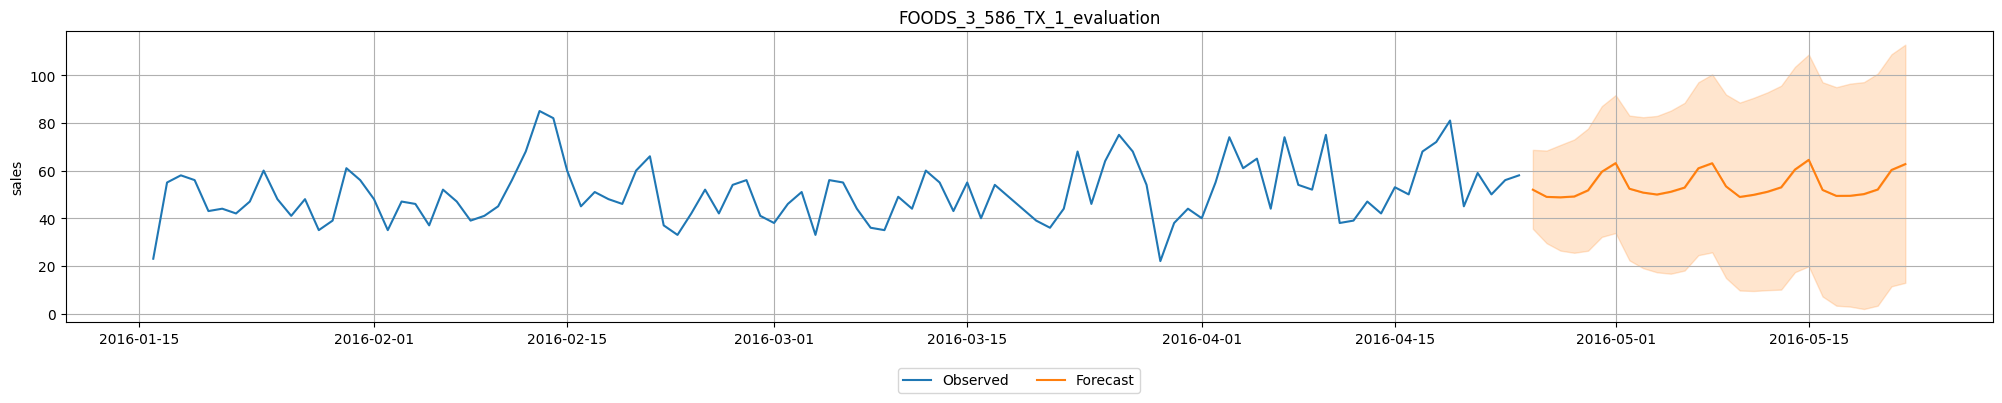

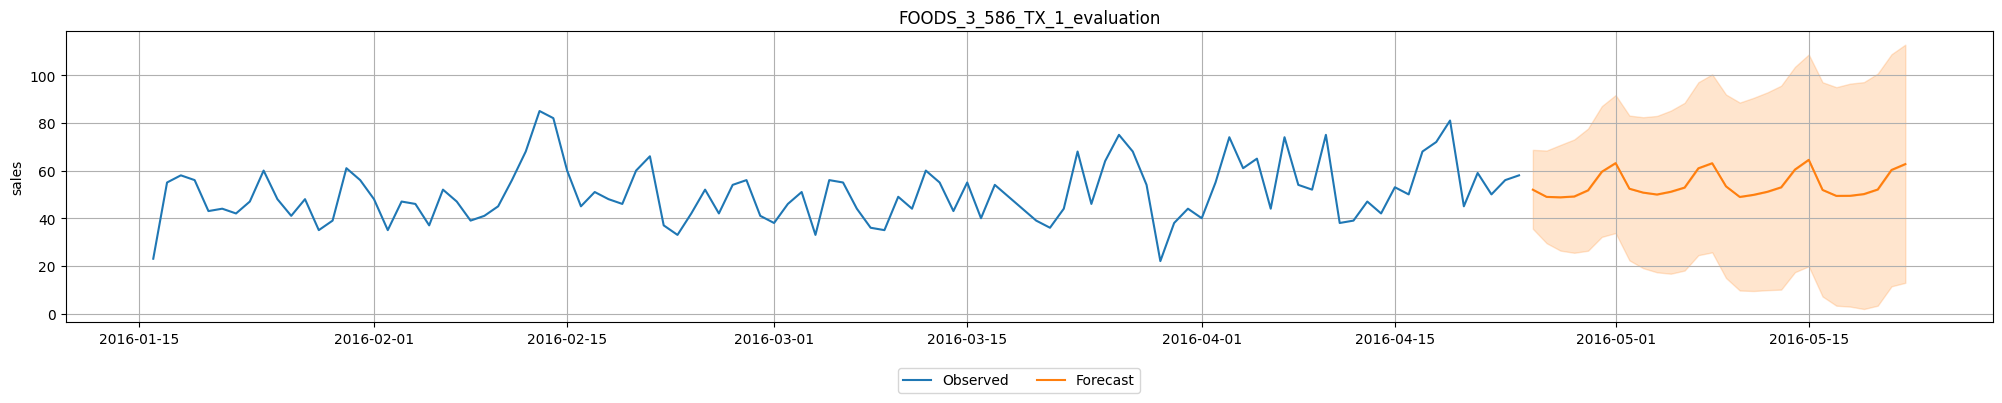

In [31]:
predictor.plot(
    data=train_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

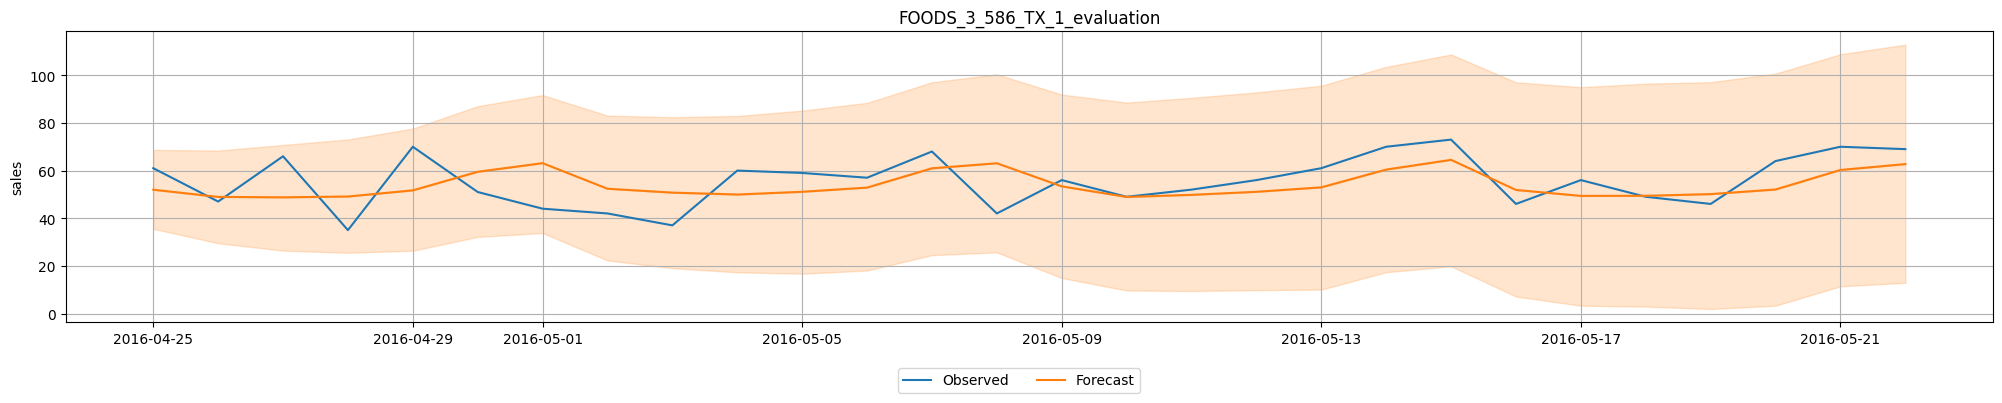

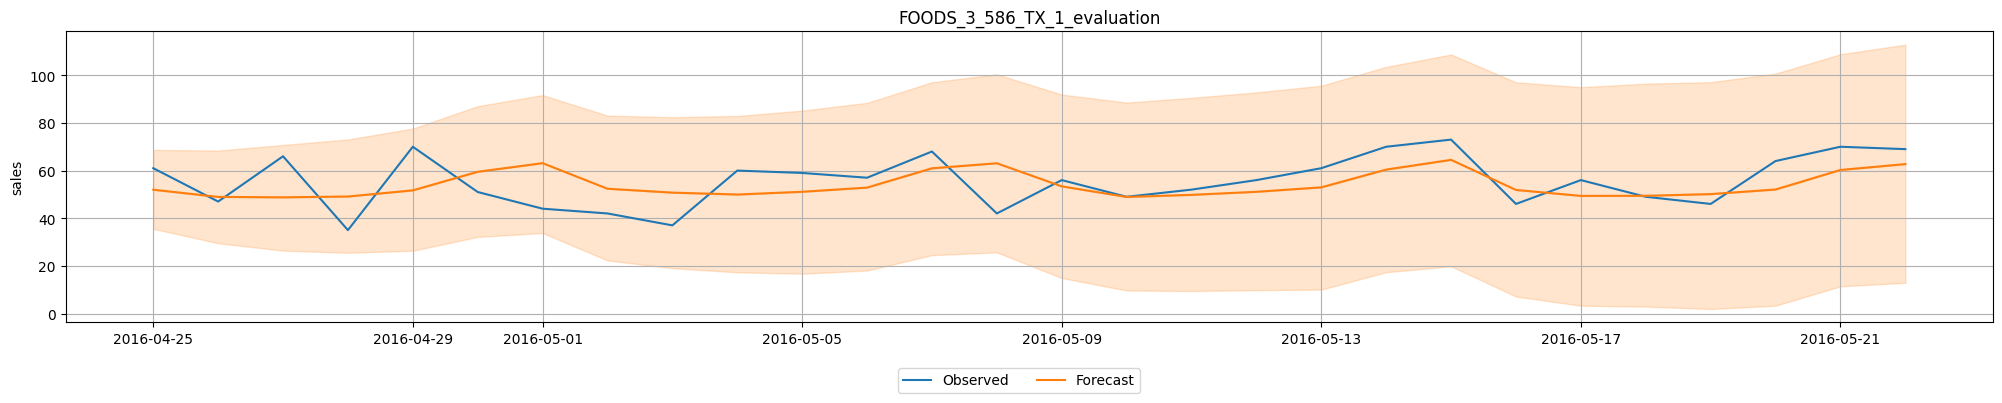

In [32]:
predictor.plot(
    data=validation_set_for_autogluon,
    predictions=validation_preds,
    item_ids=[target_item_id],
    max_history_length=28 
)

In [33]:
# Step 1: Extract the mean predictions
mean_predictions = validation_preds['mean']

# Step 2: Reshape the data
mean_predictions = mean_predictions.reset_index()
mean_predictions['forecast_day'] = mean_predictions.groupby('item_id').cumcount() + 1
validation_df = mean_predictions.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
validation_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

# Step 4: Modify 'id' for submission
validation_df['id'] = validation_df['id'].str.replace('evaluation', 'validation')


In [34]:
validation_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.140830,0.908124,1.071805,0.856848,0.946596,0.971356,0.975420,1.204305,0.948453,...,0.904145,0.975909,0.986667,1.201016,0.894862,1.014609,0.887850,0.955879,1.054285,1.014475
1,FOODS_1_001_CA_2_validation,1.114088,1.145574,1.241667,1.205736,1.192711,1.296565,1.915089,1.211053,1.169475,...,1.193913,1.246033,1.959179,1.127204,1.111721,1.249011,1.192477,1.211855,1.276347,1.938738
2,FOODS_1_001_CA_3_validation,1.134249,0.981205,1.040226,1.084070,1.097705,1.324224,1.415897,1.097174,1.174079,...,1.112075,1.219085,1.240076,1.136870,1.042929,1.077187,1.099372,1.104871,1.180676,1.127395
3,FOODS_1_001_CA_4_validation,0.443581,0.321941,0.354267,0.339192,0.365941,0.341361,0.374515,0.424844,0.327013,...,0.367579,0.365742,0.377507,0.399384,0.302285,0.336560,0.310407,0.369554,0.381794,0.416775
4,FOODS_1_001_TX_1_validation,0.367916,0.323075,0.312039,0.288118,0.302665,0.371330,0.366941,0.347070,0.378896,...,0.448607,0.489405,0.460262,0.351836,0.414395,0.421479,0.416742,0.452866,0.519238,0.493886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.311678,0.286036,0.307721,0.294607,0.298165,0.323265,0.342251,0.312639,0.313513,...,0.300306,0.329485,0.360441,0.292626,0.287097,0.286175,0.271307,0.276829,0.308720,0.326277
30486,HOUSEHOLD_2_516_TX_3_validation,0.146282,0.158763,0.161769,0.149101,0.148784,0.160569,0.167643,0.154979,0.174277,...,0.245956,0.158146,0.164472,0.155195,0.162750,0.164047,0.158559,0.155933,0.177289,0.177138
30487,HOUSEHOLD_2_516_WI_1_validation,0.056056,0.049748,0.048449,0.045986,0.058370,0.073986,0.064179,0.059566,0.054962,...,0.073113,0.069456,0.074572,0.062099,0.057002,0.060535,0.059466,0.071852,0.073656,0.069653
30488,HOUSEHOLD_2_516_WI_2_validation,0.045915,0.061607,0.074142,0.079627,0.067820,0.070459,0.080636,0.072753,0.073682,...,0.068083,0.067293,0.078765,0.075523,0.068169,0.071192,0.084798,0.077837,0.076750,0.071662


# Predict for Prediction set

In [35]:
# Step 1: Ensure 'date' is in datetime format
prediction_set['date'] = pd.to_datetime(prediction_set['date'])

# Step 2: Select only the relevant columns, ensuring 'sales' is included and filled with NaN
covariate_columns = ['dept_id', 'store_id', 'wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 
                     'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
prediction_set_for_autogluon = prediction_set[['id', 'date'] + covariate_columns].copy()

# Step 4: Convert to AutoGluon TimeSeriesDataFrame, specifying `id_column` and `timestamp_column`
prediction_set_for_autogluon = TimeSeriesDataFrame(
    data=prediction_set_for_autogluon,
    id_column='id',
    timestamp_column='date'
)

In [36]:
# Concatenate the training and validation sets
combined_df = pd.concat([train_set_for_autogluon, validation_set_for_autogluon])

# Convert the concatenated DataFrame back to a TimeSeriesDataFrame
combined_tsdf = TimeSeriesDataFrame(combined_df)

In [37]:
%time
# Step 4: Make predictions using the prediction set as known covariates
prediction_preds = predictor.predict(combined_tsdf, known_covariates=prediction_set_for_autogluon)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 20.3 µs


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


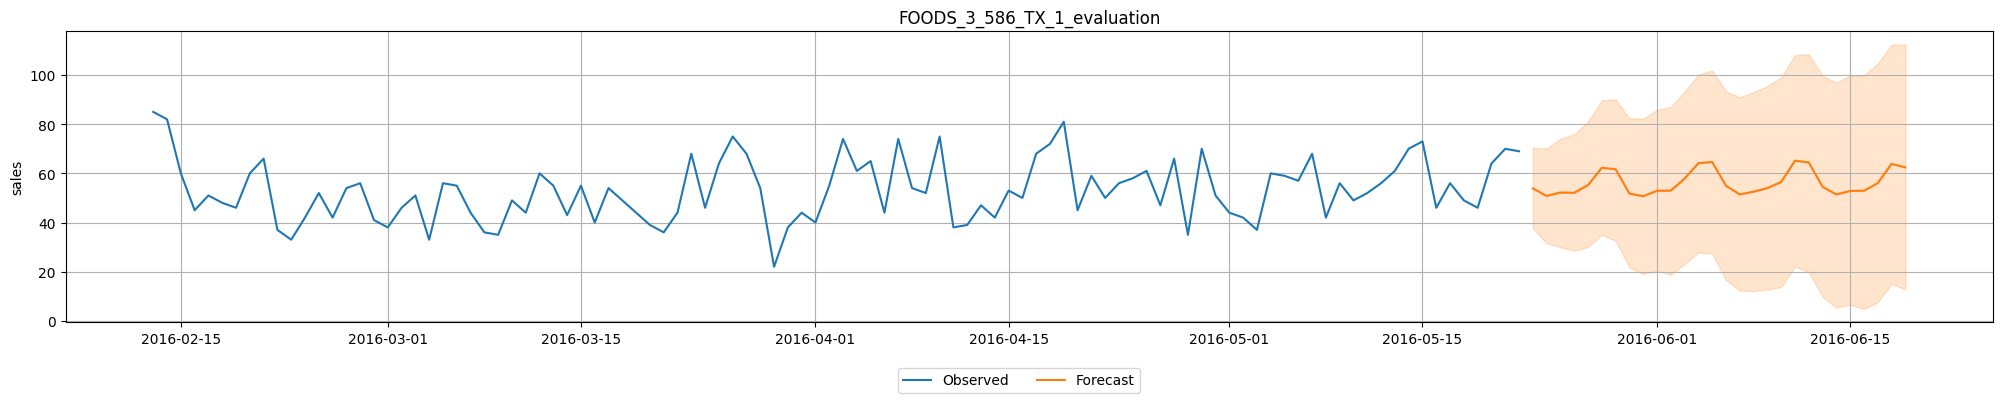

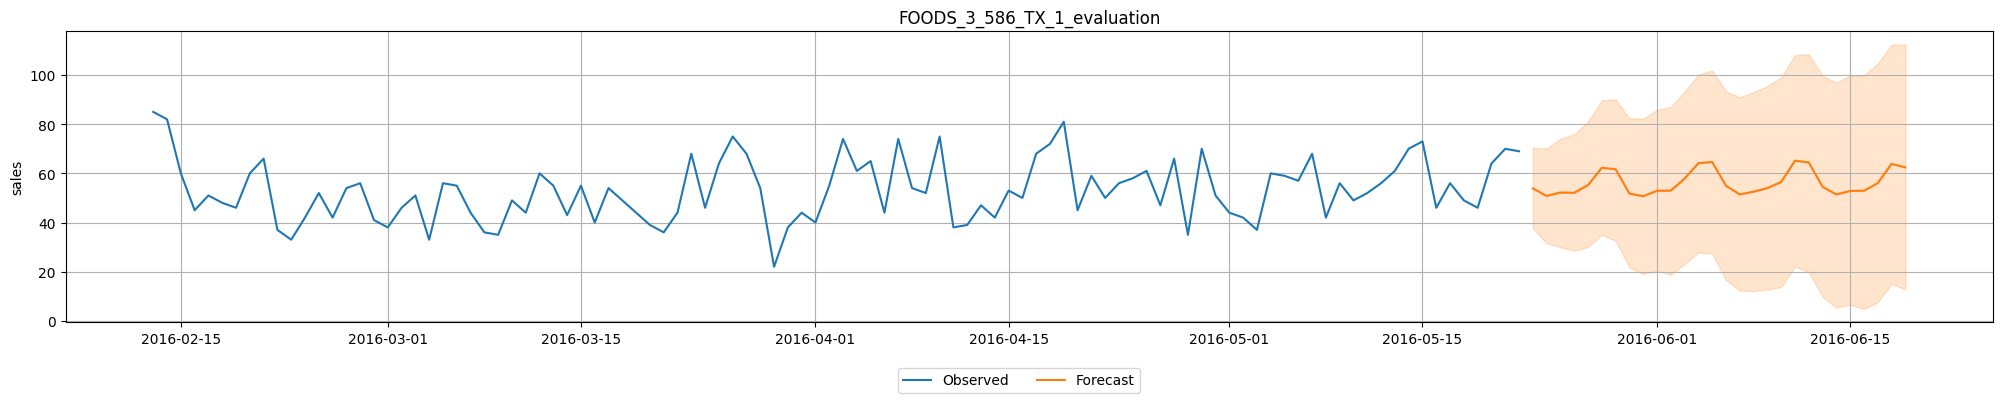

In [38]:
predictor.plot(
    data=combined_tsdf,
    predictions=prediction_preds,
    item_ids=[target_item_id],
    max_history_length=100  # Adjust as needed to display more or fewer historical points
)

In [39]:
# Step 1: Extract the mean predictions
mean_predictions1 = prediction_preds['mean']

# Step 2: Reshape the data
mean_predictions1 = mean_predictions1.reset_index()
mean_predictions1['forecast_day'] = mean_predictions1.groupby('item_id').cumcount() + 1
prediction_df = mean_predictions1.pivot(index='item_id', columns='forecast_day', values='mean').reset_index()

# Step 3: Rename columns
prediction_df.columns = ['id'] + [f'F{i}' for i in range(1, 29)]

In [40]:
prediction_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.729527,0.687655,0.700345,0.738830,0.786285,0.867014,0.843431,0.734862,0.811694,...,0.802640,0.863796,0.859221,0.720171,0.713810,0.666464,0.704898,0.730300,0.784914,0.787868
1,FOODS_1_001_CA_2_evaluation,0.870622,0.891378,0.754099,0.745698,0.903050,0.931541,0.998934,0.877901,0.938024,...,0.882751,0.971226,0.914032,0.880715,0.897889,0.779035,0.738171,0.926062,0.988750,0.865123
2,FOODS_1_001_CA_3_evaluation,1.010239,0.916930,1.022671,1.035555,1.268979,1.490896,1.250297,1.077415,1.015913,...,1.204730,1.322827,1.104063,0.933207,1.046863,0.989412,0.958888,1.213307,1.309251,1.192060
3,FOODS_1_001_CA_4_evaluation,0.326649,0.261405,0.304874,0.273850,0.268419,0.274364,0.295307,0.295387,0.274699,...,0.277560,0.271670,0.283515,0.305039,0.246393,0.292800,0.282526,0.285600,0.254789,0.257069
4,FOODS_1_001_TX_1_evaluation,0.852081,0.960382,0.776542,0.874037,0.892383,0.874577,0.963398,0.861970,0.979212,...,0.849387,0.892197,1.061649,0.831601,1.010746,0.803154,0.893950,0.875754,0.863713,0.977462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_evaluation,0.245685,0.230217,0.229820,0.235731,0.258201,0.274309,0.288518,0.265127,0.251826,...,0.245992,0.281286,0.295884,0.266785,0.240463,0.243176,0.226222,0.243667,0.271248,0.276306
30486,HOUSEHOLD_2_516_TX_3_evaluation,0.256017,0.245106,0.261961,0.269756,0.320256,0.361701,0.316711,0.259386,0.244808,...,0.307243,0.367159,0.315703,0.251722,0.257775,0.257443,0.283919,0.299542,0.369959,0.331437
30487,HOUSEHOLD_2_516_WI_1_evaluation,0.090465,0.086707,0.096785,0.106255,0.137943,0.124855,0.131512,0.098514,0.099941,...,0.103906,0.109328,0.113371,0.104863,0.093220,0.092584,0.095159,0.116309,0.109567,0.111036
30488,HOUSEHOLD_2_516_WI_2_evaluation,0.093952,0.070393,0.072561,0.074328,0.074543,0.084884,0.081878,0.087096,0.080628,...,0.073722,0.088162,0.096511,0.106968,0.075622,0.076896,0.076610,0.075743,0.083602,0.082314


# For Submission

In [41]:
# Combine validation and evaluation for submission
submit = pd.concat([validation_df, prediction_df]).reset_index(drop=True)
submit.to_csv('submission.csv', index=False)

In [42]:
submit.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.140830,0.908124,1.071805,0.856848,0.946596,0.971356,0.975420,1.204305,0.948453,...,0.904145,0.975909,0.986667,1.201016,0.894862,1.014609,0.887850,0.955879,1.054285,1.014475
1,FOODS_1_001_CA_2_validation,1.114088,1.145574,1.241667,1.205736,1.192711,1.296565,1.915089,1.211053,1.169475,...,1.193913,1.246033,1.959179,1.127204,1.111721,1.249011,1.192477,1.211855,1.276347,1.938738
2,FOODS_1_001_CA_3_validation,1.134249,0.981205,1.040226,1.084070,1.097705,1.324224,1.415897,1.097174,1.174079,...,1.112075,1.219085,1.240076,1.136870,1.042929,1.077187,1.099372,1.104871,1.180676,1.127395
3,FOODS_1_001_CA_4_validation,0.443581,0.321941,0.354267,0.339192,0.365941,0.341361,0.374515,0.424844,0.327013,...,0.367579,0.365742,0.377507,0.399384,0.302285,0.336560,0.310407,0.369554,0.381794,0.416775
4,FOODS_1_001_TX_1_validation,0.367916,0.323075,0.312039,0.288118,0.302665,0.371330,0.366941,0.347070,0.378896,...,0.448607,0.489405,0.460262,0.351836,0.414395,0.421479,0.416742,0.452866,0.519238,0.493886
5,FOODS_1_001_TX_2_validation,0.467601,0.440644,0.484997,0.499668,0.538061,0.552957,0.528142,0.506769,0.468519,...,0.537763,0.538158,0.567189,0.456652,0.458889,0.463322,0.468012,0.514359,0.540480,0.522553
6,FOODS_1_001_TX_3_validation,0.407368,0.389131,0.453200,0.492797,0.528643,0.524576,0.520229,0.464640,0.424565,...,0.501603,0.520518,0.513927,0.434932,0.373025,0.414417,0.497505,0.498459,0.521759,0.452274
7,FOODS_1_001_WI_1_validation,0.659641,0.621178,0.581037,0.515314,0.586207,1.267314,0.645435,0.590554,0.577983,...,0.718115,1.156038,0.640866,0.555872,0.580215,0.548644,0.561693,0.536935,1.180861,0.716670
8,FOODS_1_001_WI_2_validation,0.318739,0.379088,0.431261,0.315802,0.288575,0.331191,0.360795,0.345247,0.379484,...,0.334401,0.329454,0.352430,0.347833,0.355656,0.469432,0.337875,0.330397,0.338193,0.375263
9,FOODS_1_001_WI_3_validation,0.300988,0.247007,0.277525,0.236301,0.272239,0.431903,0.283393,0.261066,0.294234,...,0.300527,0.449632,0.322729,0.295684,0.278801,0.276223,0.254224,0.242621,0.446158,0.283767


In [43]:
submit.tail(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60970,HOUSEHOLD_2_516_CA_1_evaluation,0.169194,0.162535,0.166842,0.188464,0.235806,0.218126,0.231873,0.167033,0.169560,...,0.238996,0.228497,0.242177,0.178780,0.170529,0.166194,0.176701,0.232922,0.216857,0.232003
60971,HOUSEHOLD_2_516_CA_2_evaluation,0.336635,0.328440,0.351274,0.340403,0.380796,0.437921,0.345751,0.306054,0.319952,...,0.357221,0.414233,0.334932,0.302828,0.325887,0.315810,0.322036,0.348297,0.448117,0.355657
60972,HOUSEHOLD_2_516_CA_3_evaluation,0.173389,0.105007,0.134889,0.128818,0.123027,0.149325,0.135348,0.140621,0.144489,...,0.126065,0.158386,0.141470,0.135272,0.142931,0.117715,0.124782,0.122892,0.150269,0.122839
60973,HOUSEHOLD_2_516_CA_4_evaluation,0.123250,0.111791,0.113881,0.109721,0.101016,0.113314,0.113838,0.119241,0.127300,...,0.119801,0.128981,0.134624,0.124388,0.124627,0.129646,0.123104,0.124746,0.133590,0.129890
60974,HOUSEHOLD_2_516_TX_1_evaluation,0.041451,0.044076,0.042163,0.042116,0.044839,0.050709,0.047586,0.045342,0.045386,...,0.057695,0.062563,0.061382,0.050590,0.049764,0.053337,0.050459,0.056180,0.061851,0.062931
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.245685,0.230217,0.229820,0.235731,0.258201,0.274309,0.288518,0.265127,0.251826,...,0.245992,0.281286,0.295884,0.266785,0.240463,0.243176,0.226222,0.243667,0.271248,0.276306
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.256017,0.245106,0.261961,0.269756,0.320256,0.361701,0.316711,0.259386,0.244808,...,0.307243,0.367159,0.315703,0.251722,0.257775,0.257443,0.283919,0.299542,0.369959,0.331437
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.090465,0.086707,0.096785,0.106255,0.137943,0.124855,0.131512,0.098514,0.099941,...,0.103906,0.109328,0.113371,0.104863,0.093220,0.092584,0.095159,0.116309,0.109567,0.111036
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.093952,0.070393,0.072561,0.074328,0.074543,0.084884,0.081878,0.087096,0.080628,...,0.073722,0.088162,0.096511,0.106968,0.075622,0.076896,0.076610,0.075743,0.083602,0.082314
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.078994,0.073866,0.075341,0.077196,0.095502,0.108272,0.098566,0.089753,0.087144,...,0.088001,0.119723,0.097254,0.093667,0.090459,0.091919,0.089728,0.091817,0.105581,0.090580
